# Financial Health Analysis by scraping data from Moneycontrol

### **Problem Definition:** Financial Health Analysis through Web Scraping from Moneycontrol

**Background:**
Companies, investors, and financial analysts often rely on financial data to assess the health and performance of businesses. Moneycontrol is a popular financial news and information portal that provides a wealth of financial data for publicly listed companies. The problem is to develop a web scraping solution to extract key financial indicators from Moneycontrol for a given company and perform a comprehensive analysis of its financial health.

**Objective:**
The objective is to automate the extraction of relevant financial data from Moneycontrol and conduct a financial health analysis for a specified company. The analysis should include key financial ratios, profitability indicators, liquidity measures, and other relevant metrics. The goal is to provide valuable insights into the company's financial standing and performance.

**Key Tasks:**

Web Scraping:

Develop a web scraping solution to extract financial data from Moneycontrol for a given company.
Collect data for key financial indicators, including but not limited to revenue, net profit, debt levels, current assets, and current liabilities.
Data Cleaning and Processing:

Clean and preprocess the extracted data to handle missing values and ensure data accuracy.
Convert the data into a structured format suitable for analysis.
Financial Health Metrics:

Calculate and analyze key financial ratios such as current ratio, quick ratio, debt-to-equity ratio, return on equity, and others.
Compute profitability metrics, liquidity ratios, and efficiency indicators.
Visualization:

Create visualizations (charts, graphs) to present the financial health analysis in an easily understandable format.
Visualize trends and variations in financial indicators over time.
Comparison and Benchmarking:

Compare the company's financial metrics with industry benchmarks and competitors.
Provide insights into how the company performs relative to its peers.

## Implementation

### Neccessary Libraries 

In [2]:
from selenium import webdriver # for scraping # install using- pip install selenium
from selenium.webdriver.common.by import By
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import textwrap

### Search for the company in money control and give the company link as the url.

In [3]:
url = "https://www.moneycontrol.com/india/stockpricequote/food-processing/britanniaindustries/BI"  # replace with company URL

## Functions to Scrape data and visualize

In [4]:
#This function gets the links to pages of competitors of the company
def get_competitor_links(driver):
    #find xpath of the competitors table
    links = driver.find_elements(By.XPATH,'//*[@id="peers"]/div[2]/table//a')
    competitor_links = []
    #extract the links of the competitors
    for link in links[1:]:
        competitor_links.append(link.get_attribute('href'))

    return competitor_links

In [5]:
#This function gets the data of ratios of the company
def get_ratio_data(ratio_link):
    #use pandas to read the html table of ratios using the ratio page link
    ratio_table = pd.read_html(ratio_link,header=0, index_col=0)
    #remove the last column which is empty
    ratio_table = ratio_table[0].iloc[:, :-1]

    # Reverse the order of columns
    ratio_table = ratio_table.iloc[:, ::-1]
    
    #mention the ratios to be scraped
    ratios = ['Current Ratio (X)', 'Quick Ratio (X)', 'Total Debt/Equity (X)', 
          'PBDIT Margin (%)', 'PBIT Margin (%)', 'PBT Margin (%)', 
          'Net Profit Margin (%)','Return on Capital Employed (%)', 'Return on Assets (%)', 
          'Inventory Turnover Ratio (X)', 'Asset Turnover Ratio (%)', 
          'Price/BV (X)', 'Basic EPS (Rs.)']
    ratio_trend = ratio_table.loc[ratios]

    #return the ratios
    return ratio_trend

In [6]:
#This function gets the data of PnL of the company
def get_PnL_data(PnL_link):
    #use pandas to read the html table of PnL using the PnL page link
    PnL_table = pd.read_html(PnL_link,header=0, index_col=0)
    #remove the last column which is empty
    PnL_table = PnL_table[0].iloc[:, :-1]
    PnL_trend = PnL_table.loc[['Revenue From Operations [Net]','Profit/Loss For The Period']]
    PnL_trend = PnL_trend.T
    return PnL_trend


In [7]:
#This function gets the data of Balance Sheet of the company
def get_balance_sheet_data(balance_sheet_link):
    #use pandas to read the html table of Balance Sheet using the Balance Sheet page link
    BS_table = pd.read_html(balance_sheet_link,header=0, index_col=0)
    #remove the last column which is empty
    BS_table = BS_table[0].iloc[:, :-1]
    BS_trend = BS_table.loc[['Tangible Assets','Long Term Borrowings']]
    BS_trend = BS_trend.T
    return BS_trend

In [8]:
#This function gets the data of the company
def get_company_data(url):
    driver = webdriver.Chrome()
    driver.get(url)

    # get company name
    company_name = driver.find_element(By.XPATH,'//*[@id="stockName"]/h1').text

    # get the elemements containing links to PnL, Balance Sheet and Ratios pages
    balance_sheet_path=driver.find_element(By.XPATH,'//*[@id="standalone"]/div[2]/div[2]/div/ul/li[1]/a')
    PnL_path=driver.find_element(By.XPATH,'//*[@id="standalone"]/div[2]/div[2]/div/ul/li[2]/a')
    ratio_path=driver.find_element(By.XPATH,'//*[@id="standalone"]/div[2]/div[2]/div/ul/li[8]/a')

    # get the links to PnL, Balance Sheet and Ratios pages
    balance_sheet_link=balance_sheet_path.get_attribute('href')
    PnL_link=PnL_path.get_attribute('href')
    ratio_link=ratio_path.get_attribute('href')

    # get the data of PnL, Balance Sheet and Ratios pages using the predefined functions
    PnL_data=get_PnL_data(PnL_link)
    balance_sheet_data=get_balance_sheet_data(balance_sheet_link)
    ratio_data=get_ratio_data(ratio_link)

    #concatenate the data of PnL, Balance Sheet as a single dataframe called trend_df
    trend_df=pd.concat([PnL_data,balance_sheet_data],axis=1)
    
    #get the links to the pages of competitors of the company using the predefined function
    competitors_path=get_competitor_links(driver)

    driver.quit()
    
    return company_name,trend_df,ratio_data,competitors_path

company_name,trend_df,company_ratio_data,competitors_path=get_company_data(url)


In [9]:
#This function gets the data of competitors of the company
def get_competitors_data(competitors_path):
    competitors_data=pd.DataFrame()
    for competitor in competitors_path:
        #opens every competitor page and extracts the data of ratios
        driver = webdriver.Chrome()
        driver.get(competitor)
        competitor_name = driver.find_element(By.XPATH,'//*[@id="stockName"]/h1').text
        
        ratio_path=driver.find_element(By.XPATH,'//*[@id="standalone"]/div[2]/div[2]/div/ul/li[8]/a')
        ratio_link=ratio_path.get_attribute('href')
        
        driver.quit()
        ratio_data=get_ratio_data(ratio_link)

        #concatenate the data of ratios of competitors as a single dataframe called competitors_data
        competitors_data[competitor_name]=ratio_data.mean(axis=1)


    return competitors_data

competitors_data=get_competitors_data(competitors_path)
competitors_data[company_name]=company_ratio_data.mean(axis=1)
competitors_data['industry mean']=competitors_data.mean(axis=1)

In [10]:
#function to calculate CAGR
def calculate_cagr(beginning_value, ending_value, years):
    return (ending_value / beginning_value) ** (1/years) - 1

In [11]:
#function to plot the trend
def trend_analysis(trend_df):
    trend_df=trend_df.apply(pd.to_numeric)

    #reverse the dataframe to plot the trend from oldest to latest
    trend_df=trend_df.iloc[::-1]
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over
    for i, column in enumerate(trend_df.columns[:4]):  # Only take the first 4 columns
        cagr = calculate_cagr(trend_df[column].iloc[0],trend_df[column].iloc[-1],  len(trend_df))
        if cagr > 0:
            print(f"{column} has a positive CAGR of {cagr:.2%}")
        else:
            print(f"{column} has a negative CAGR of {cagr:.2%}")
        #plot the trend-add title and axis labels
        trend_df[column].plot(ax=axs[i])
        axs[i].set_title(f"{column} (CAGR: {cagr:.2%})")
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('Value')
        axs[i].text(0.5, 0.5, f"CAGR: {cagr:.2%}", transform=axs[i].transAxes)
    plt.tight_layout()
    plt.show()


In [12]:
def ratio_analysis(ratio_list,company_ratio_data,competitors_data):
    for ratio in ratio_list:
        print(f"Five Year average {ratio} of {company_name} is {competitors_data.loc[ratio].iloc[-2]:.2f}")
        print(f"Five Year average {ratio} of industry is {competitors_data['industry mean'].loc[ratio]:.2f}")
        if company_ratio_data.loc[ratio].iloc[0] > competitors_data.loc[ratio].mean():
            print(f"{ratio} of {company_name} is higher than its competitors")
        else:
            print(f"{ratio} of {company_name} is lower than its competitors")
        print('\n')

        # Create a new figure
        plt.figure(figsize=(10, 5))

        # Plot the trend in the first subplot
        plt.subplot(1, 2, 1)
        company_ratio_data.loc[ratio].plot()
        plt.title(f"{ratio} of {company_name}")
        plt.xlabel('Year')
        plt.ylabel('Value')

        # Plot the competitor comparison in the second subplot
        plt.subplot(1, 2, 2)
        competitors_data.loc[ratio].plot(kind='bar')
        plt.title(f"{ratio} of competitors")
        plt.xlabel('Competitors')
        plt.ylabel('Value')

        # Wrap the x-axis labels
        labels = [textwrap.fill(label, 10) for label in competitors_data.columns]
        plt.xticks(ticks=range(len(labels)), labels=labels, rotation='horizontal')  # Make the x-axis labels horizontal

        # Adjust the padding between and around the subplots
        plt.tight_layout()

        # Display the figure with the subplots
        plt.show()



## Results

## Trend Analysis
**Revenue From Operations [Net]:** The total revenue generated by a company from its primary business activities, excluding deductions like discounts, returns, and allowances.

*Significance:* Revenue is a fundamental indicator of a company's ability to generate income. It is crucial for assessing the company's business performance, growth potential, and market competitiveness.

*Trend Interpretation:* In general, a rising trend in revenue is positive, indicating business growth. A declining trend may raise concerns about the company's ability to maintain or increase its market share.

**Profit/Loss For The Period:** The net profit or loss a company incurs during a specific time period after deducting all expenses, taxes, and other costs from total revenue.

*Significance:* Profitability is a key measure of financial health. Positive profits indicate the company's ability to generate a surplus after covering all costs, while losses may suggest financial challenges.

*Trend Interpretation:* Ideally, a positive and increasing trend in profits is desirable. However, the interpretation may vary based on the industry. Some industries may have inherently lower profit margins, and consistent profits are more important than the magnitude.

**Tangible Assets:** Physical assets with a measurable value that can be touched or seen, such as buildings, machinery, land, and equipment.

*Significance:* Tangible assets are crucial for a company's operations and growth. They represent investments in physical infrastructure and contribute to the company's overall value.

*Trend Interpretation:* Generally, a rising trend in tangible assets is positive, indicating investment in and expansion of physical resources. A declining trend may signal divestment or depreciation of existing assets.

**Long Term Borrowings:** Debts and loans with a maturity period of more than one year, representing liabilities that the company needs to repay over an extended period.

*Significance:* Long-term borrowings indicate the company's leverage and its reliance on external funding for long-term projects and operations.

*Trend Interpretation:* The ideal trend in long-term borrowings may vary based on the company's financial strategy and industry norms. In general, a consistent or decreasing trend may be viewed positively, while a sharp increase may raise concerns about the company's financial risk and ability to service its debt.

Revenue From Operations [Net] has a positive CAGR of 8.03%
Profit/Loss For The Period has a positive CAGR of 13.77%
Tangible Assets has a positive CAGR of 11.58%
Long Term Borrowings has a positive CAGR of 469.02%


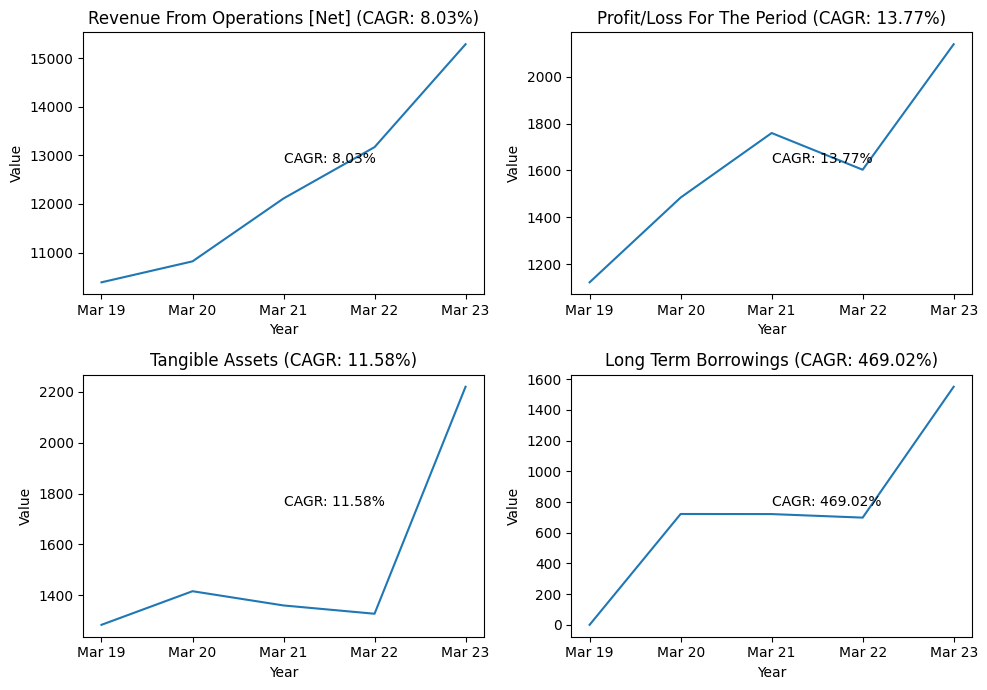

In [13]:
trend_analysis(trend_df)

## Liquidity Analysis

Current Ratio (X):

Current Ratio is a liquidity ratio that measures a company's ability to cover its short-term liabilities with its short-term assets. It is calculated as the ratio of current assets to current liabilities.

Significance: A current ratio above 1 indicates that a company has more assets than liabilities in the short term, suggesting good liquidity.

Interpretation: A current ratio higher than the industry average may indicate better short-term liquidity. However, if the current ratio is significantly higher than competitors, it might suggest that the company is not efficiently utilizing its assets.

Quick Ratio (X):

Quick Ratio, also known as the Acid-Test Ratio, is a liquidity ratio that measures a company's ability to meet its short-term obligations with its most liquid assets. It excludes inventory from current assets.

Significance: The quick ratio provides a more conservative measure of liquidity, focusing on assets that can be quickly converted to cash.

Interpretation: A quick ratio higher than industry peers may indicate strong liquidity without relying heavily on inventory. A lower quick ratio compared to competitors may suggest potential difficulty in meeting short-term obligations without selling inventory.

Five Year average Current Ratio (X) of Britannia Industries Ltd. is 1.34
Five Year average Current Ratio (X) of industry is 1.51
Current Ratio (X) of Britannia Industries Ltd. is higher than its competitors




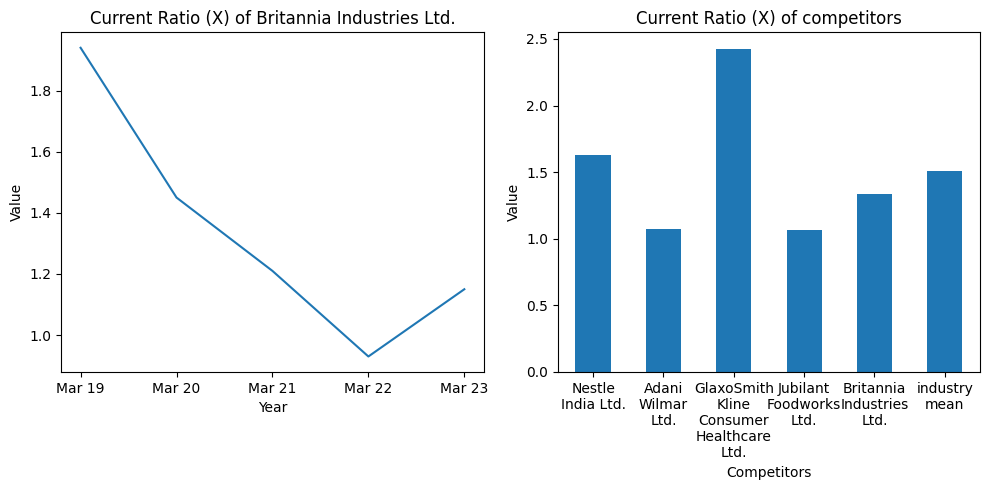

Five Year average Quick Ratio (X) of Britannia Industries Ltd. is 1.01
Five Year average Quick Ratio (X) of industry is 1.14
Quick Ratio (X) of Britannia Industries Ltd. is higher than its competitors




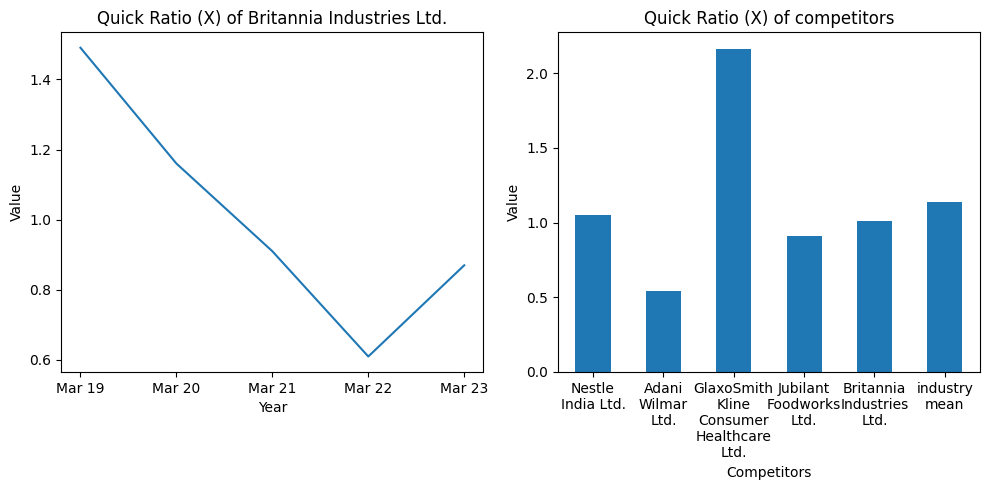

In [14]:
ratio_analysis(['Current Ratio (X)', 'Quick Ratio (X)'],company_ratio_data,competitors_data)

## Solvency Ratios

Total Debt/Equity (X):

Total Debt/Equity Ratio measures the proportion of a company's financing that comes from debt compared to equity. It is calculated as the ratio of total debt to shareholders' equity.

Significance: A lower ratio indicates less reliance on debt for financing, which can be favorable for financial stability.

Interpretation: A lower total debt/equity ratio compared to competitors may suggest a more conservative capital structure, indicating less reliance on debt for financing. However, the interpretation may vary based on industry norms.

Five Year average Total Debt/Equity (X) of Britannia Industries Ltd. is 0.51
Five Year average Total Debt/Equity (X) of industry is 0.37
Total Debt/Equity (X) of Britannia Industries Ltd. is lower than its competitors




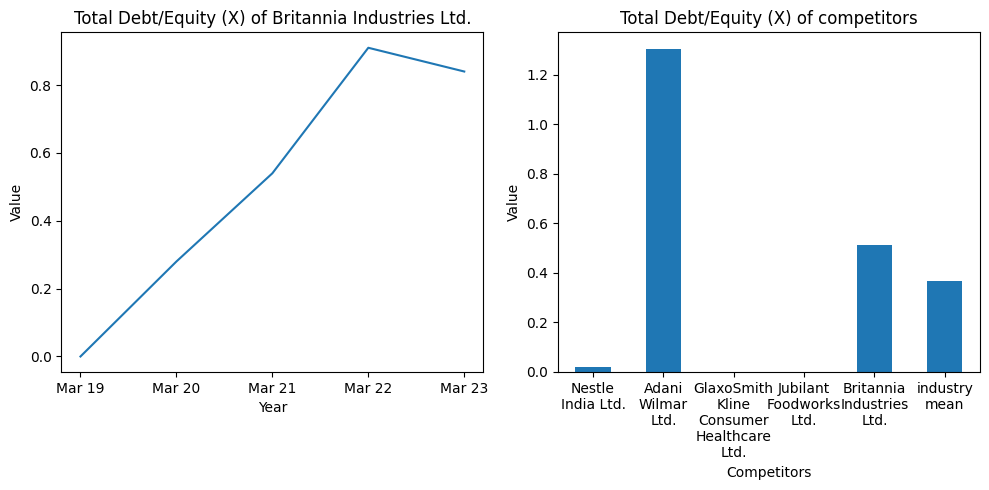

In [15]:
ratio_analysis(['Total Debt/Equity (X)'],company_ratio_data,competitors_data)

## Profitability Analysis

PBDIT Margin (%):

PBDIT (Profit Before Depreciation, Interest, and Taxes) Margin represents the percentage of total revenue that remains after deducting operating expenses but before considering interest, taxes, and depreciation.

Significance: PBDIT Margin reflects the operational efficiency of a company.

Interpretation: A higher PBDIT margin compared to competitors indicates better operational efficiency in generating profit before considering interest, taxes, and depreciation.

PBIT Margin (%):

PBIT (Profit Before Interest and Taxes) Margin is the percentage of total revenue that remains after deducting operating expenses and before considering interest and taxes.

Significance: PBIT Margin focuses on operational profitability without including the impact of interest.

Interpretation: Comparing PBIT margins with industry peers provides insights into operational profitability without the impact of interest. A higher margin may suggest better cost management.

PBT Margin (%):

PBT (Profit Before Taxes) Margin is the percentage of total revenue that remains after deducting all operating expenses but before considering taxes.

Significance: PBT Margin provides insights into profitability before the impact of taxes.

Interpretation: Comparing PBT margins with competitors helps assess pre-tax profitability. A higher margin may indicate effective cost control and operational efficiency.

Interpretation: A higher net profit margin compared to competitors indicates better overall profitability after considering all expenses. It suggests effective management of both operational and financial aspects.

Net Profit Margin (%):

Net Profit Margin is the percentage of total revenue that represents a company's net profit after deducting all operating expenses, interest, taxes, and other costs.

Significance: Net Profit Margin is a key measure of overall profitability.

Return on Capital Employed (%):

Return on Capital Employed (ROCE) measures the efficiency of a company in generating profits from its capital employed (both equity and debt).

Significance: ROCE provides insights into the effectiveness of capital utilization.

Interpretation: A higher ROCE compared to industry peers indicates better efficiency in generating profits from capital employed. It suggests effective use of both equity and debt.

Return on Assets (%):

Return on Assets (ROA) measures a company's ability to generate profits from its total assets.

Significance: ROA indicates how efficiently a company uses its assets to generate earnings.

Interpretation: Comparing ROA with competitors helps assess how efficiently a company utilizes its assets to generate earnings. A higher ROA suggests better asset utilization.

Five Year average PBDIT Margin (%) of Britannia Industries Ltd. is 19.09
Five Year average PBDIT Margin (%) of industry is 19.56
PBDIT Margin (%) of Britannia Industries Ltd. is lower than its competitors




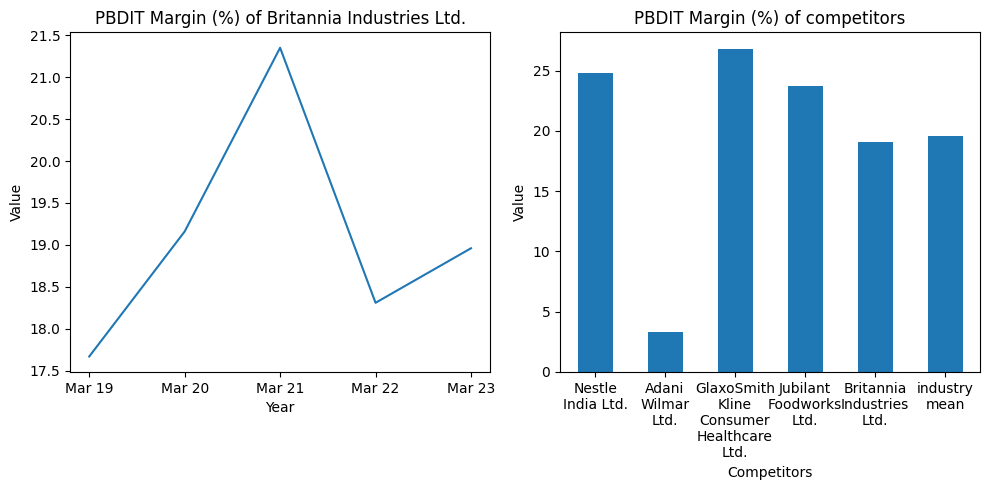

Five Year average PBIT Margin (%) of Britannia Industries Ltd. is 17.78
Five Year average PBIT Margin (%) of industry is 16.65
PBIT Margin (%) of Britannia Industries Ltd. is lower than its competitors




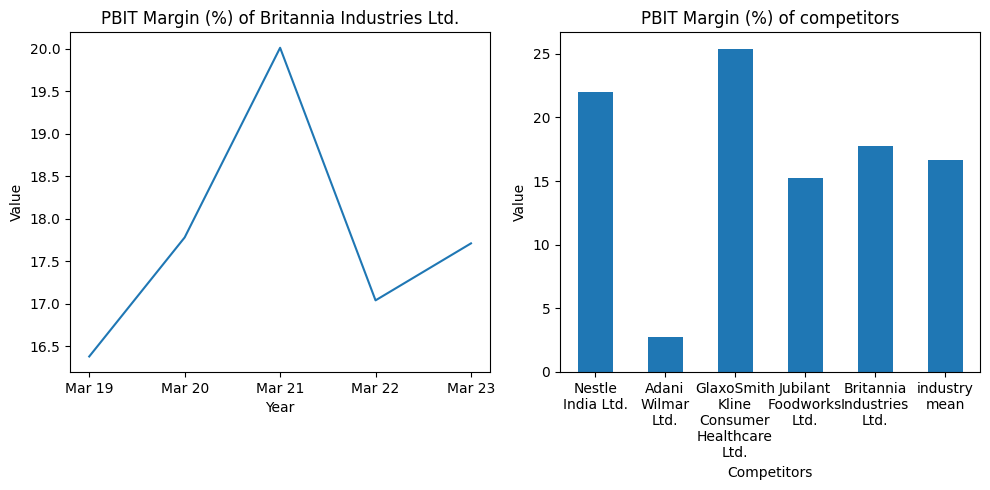

Five Year average PBT Margin (%) of Britannia Industries Ltd. is 17.43
Five Year average PBT Margin (%) of industry is 15.16
PBT Margin (%) of Britannia Industries Ltd. is higher than its competitors




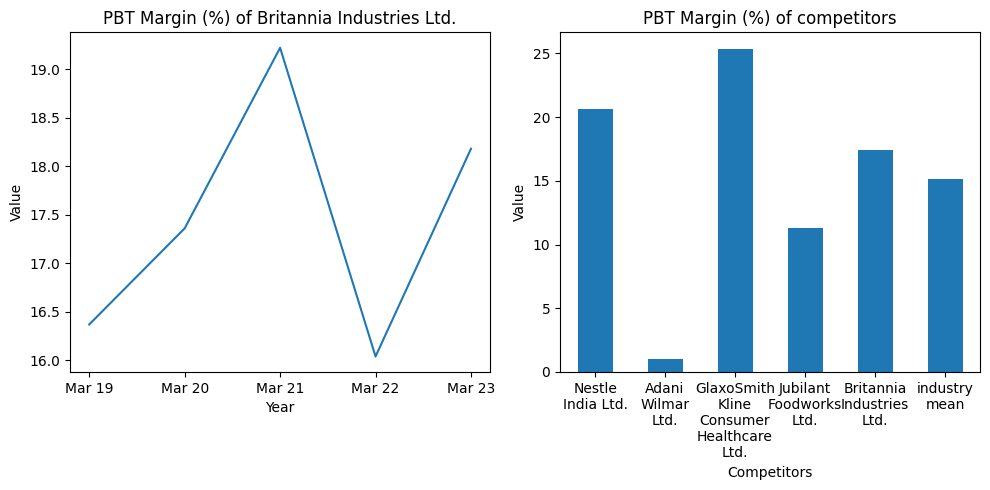

Five Year average Net Profit Margin (%) of Britannia Industries Ltd. is 12.82
Five Year average Net Profit Margin (%) of industry is 10.62
Net Profit Margin (%) of Britannia Industries Ltd. is higher than its competitors




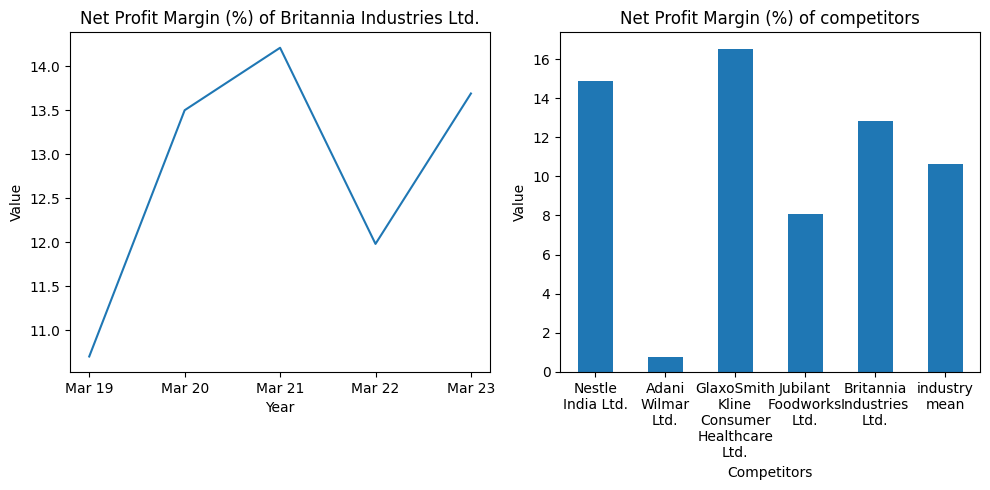

Five Year average Return on Capital Employed (%) of Britannia Industries Ltd. is 54.31
Five Year average Return on Capital Employed (%) of industry is 35.69
Return on Capital Employed (%) of Britannia Industries Ltd. is higher than its competitors




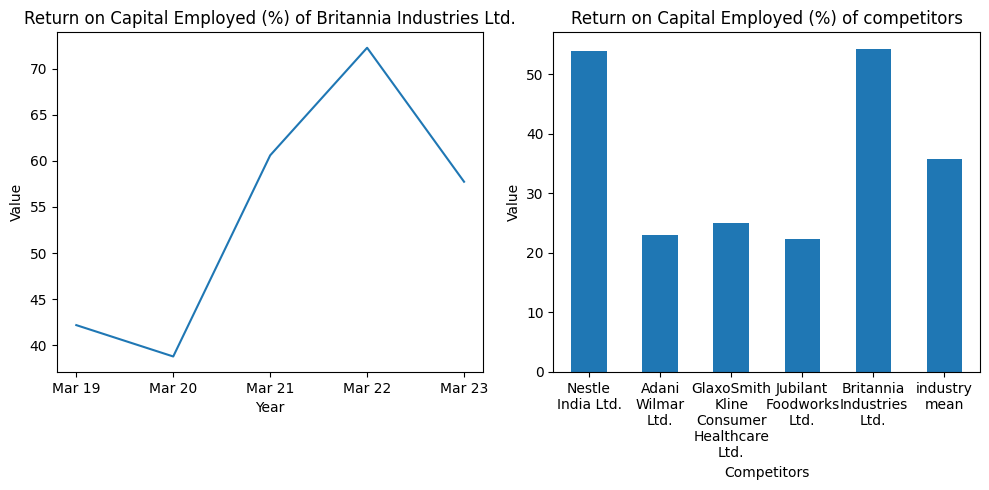

Five Year average Return on Assets (%) of Britannia Industries Ltd. is 22.34
Five Year average Return on Assets (%) of industry is 14.71
Return on Assets (%) of Britannia Industries Ltd. is higher than its competitors




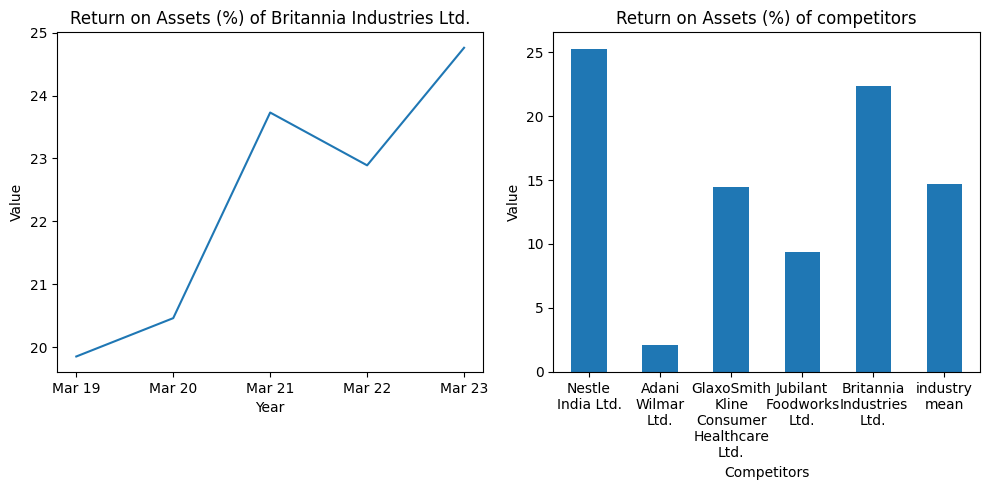

Five Year average Basic EPS (Rs.) of Britannia Industries Ltd. is 67.39
Five Year average Basic EPS (Rs.) of industry is 95.34
Basic EPS (Rs.) of Britannia Industries Ltd. is lower than its competitors




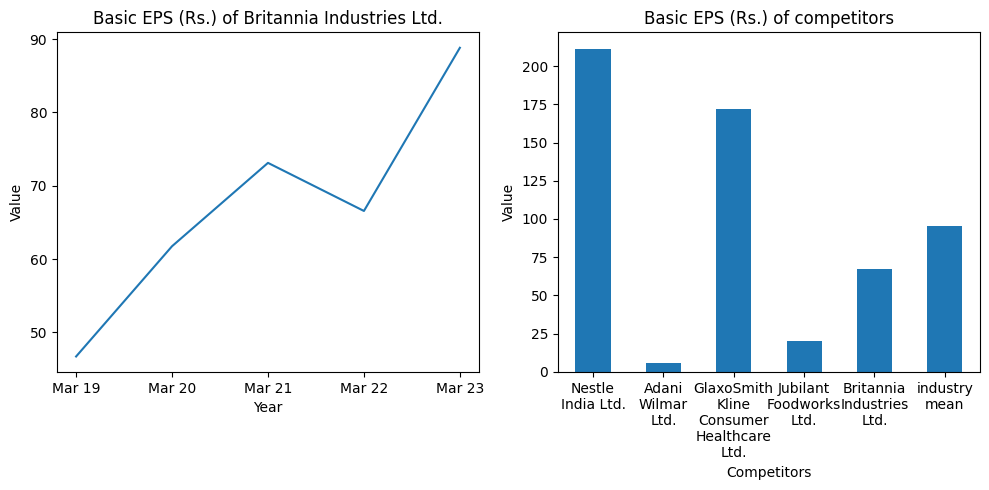

In [16]:
ratios=['PBDIT Margin (%)', 'PBIT Margin (%)', 'PBT Margin (%)', 
          'Net Profit Margin (%)', 'Return on Capital Employed (%)', 'Return on Assets (%)',
          'Basic EPS (Rs.)']
ratio_analysis(ratios,company_ratio_data,competitors_data)

## Efficiency Analysis

Inventory Turnover Ratio (X):

Inventory Turnover Ratio measures the efficiency of a company in managing its inventory. It is calculated as the ratio of the cost of goods sold to average inventory.
Significance: A higher ratio indicates faster inventory turnover, suggesting efficient inventory management.

Interpretation: A higher inventory turnover ratio compared to competitors indicates efficient management of inventory. It suggests that the company is selling its inventory quickly.

Asset Turnover Ratio (%):

Asset Turnover Ratio measures a company's ability to generate revenue from its total assets. It is calculated as the ratio of total revenue to average total assets.

Significance: A higher ratio suggests efficient utilization of assets to generate sales.

Interpretation: A higher asset turnover ratio compared to industry peers suggests better efficiency in generating revenue from total assets.

Five Year average Inventory Turnover Ratio (X) of Britannia Industries Ltd. is 11.24
Five Year average Inventory Turnover Ratio (X) of industry is 12.00
Inventory Turnover Ratio (X) of Britannia Industries Ltd. is higher than its competitors




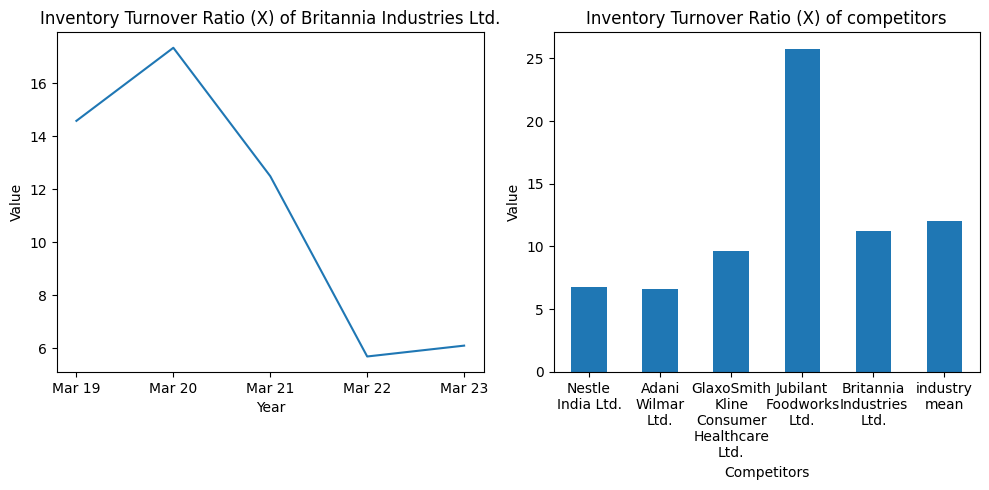

Five Year average Asset Turnover Ratio (%) of Britannia Industries Ltd. is 101.53
Five Year average Asset Turnover Ratio (%) of industry is 66.75
Asset Turnover Ratio (%) of Britannia Industries Ltd. is higher than its competitors




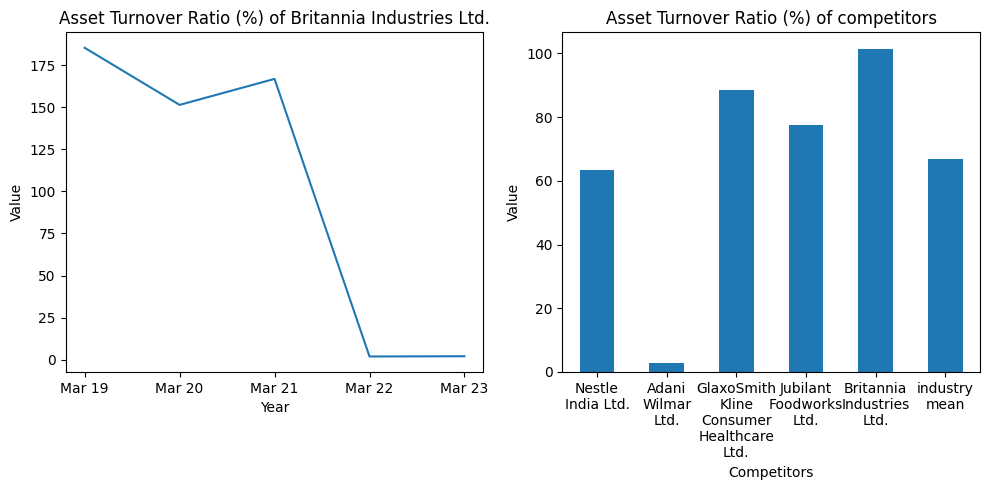

In [17]:
ratio_analysis(['Inventory Turnover Ratio (X)', 'Asset Turnover Ratio (%)'],company_ratio_data,competitors_data)